In [2]:
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

import json
import math
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import nltk
from nltk.tokenize import word_tokenize
import re
import random
from tqdm import tqdm


from BBPETokenizer import BPETokenizer

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
with open('COMP90042_2024-main/data/train-claims.json') as f:
    train_data = json.load(f)
with open('COMP90042_2024-main\data\dev-claims.json') as f:
    test_data = json.load(f)
    
with open('COMP90042_2024-main\data\dev-claims-baseline.json') as f:
    dev_data = json.load(f)

with open('COMP90042_2024-main\data\evidence.json') as f:
    evidence_data = json.load(f)

print(len(train_data))
print(len(evidence_data))

1228
1208827


#### Preprocess

In [5]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')


def processText(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'<.*?>', '', text)

    words = word_tokenize(text.lower())

    words = [w for w in words if w not in stopwords]

    return ' '.join(words)
    

[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


### BPE Vocabulary

In [6]:
tokenizer = BPETokenizer()
tokenizer.load('bbpe.bin')

In [ ]:
def encoding(claim, evidence, max_length):
    special_dict = tokenizer.special_voca()
    result = tokenizer.encode('[CLS]' + claim + '[SEP]' + evidence + '[SEP]')
    if len(result) > max_length*2:
        claim_encode = tokenizer.encode(claim)
        evidence_encode = tokenizer.encode(evidence)
        result = [special_dict['[CLS]']] + claim_encode[:max_length-1] + [special_dict['[SEP]']] + evidence_encode[:max_length-2] + [special_dict['[SEP]']]
    else:
        result += [special_dict['[PAD]']] * (max_length*2 - len(result))
    return result

#### Data loader

In [8]:
labels = ["SUPPORTS", "NOT_ENOUGH_INFO", "REFUTES", "DISPUTED"]
labelsid = {"SUPPORTS": 0, "NOT_ENOUGH_INFO": 1, "REFUTES": 2, "DISPUTED": 3}
specials = ['[CLS]', '[SEP]', '[PAD]', '[UNK]', '[MASKED]']

In [9]:
processed_train_data = []
processed_test_data = []

for id, values in train_data.items():
    for evidence in values['evidences']:
        processed_train_data.append([id, processText(values['claim_text']), processText(evidence_data[evidence]), labelsid[values['claim_label']]])
df_train_data = pd.DataFrame(processed_train_data, columns=['claim', 'text', 'evidence', 'label'])


for id, values in test_data.items():
    for evidence in values['evidences']:
        processed_test_data.append([id, processText(values['claim_text']), processText(evidence_data[evidence]), labelsid[values['claim_label']]])
df_test_data = pd.DataFrame(processed_test_data, columns=['claim', 'text', 'evidence', 'label'])
df_train_data.head()

claim                                               text  \
0  claim-1937  scientific evidence co2 pollutant higher co2 c...   
1  claim-1937  scientific evidence co2 pollutant higher co2 c...   
2  claim-1937  scientific evidence co2 pollutant higher co2 c...   
3   claim-126  el niño drove record highs global temperatures...   
4   claim-126  el niño drove record highs global temperatures...   

                                            evidence  label  
0  high concentrations 100 times atmospheric conc...      3  
1  plants grow much 50 percent faster concentrati...      3  
2  higher carbon dioxide concentrations favourabl...      3  
3  climate change due natural forces human activi...      2  
4  acceleration due mostly humancaused global war...      2

In [10]:
class ClassificationDataset(Dataset):
    def __init__(self, data, label_coloum):
        super().__init__()
        self.dataframe = data
        self.label = label_coloum
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        text_tensor = torch.tensor(encoding(row['text'], row['evidence'], 512), dtype=torch.long)  # 转换为 tensor
        label_tensor = torch.tensor(row[self.label], dtype=torch.long)  # 也转换为 tensor
        return text_tensor, label_tensor


In [11]:
label_coloum = 'label'

train_dataset = ClassificationDataset(df_train_data, label_coloum=label_coloum)
train_dataloader = DataLoader(train_dataset)

test_dataset = ClassificationDataset(df_test_data, label_coloum=label_coloum)
test_dataloader = DataLoader(test_dataset)

### Model Structure

##### Positional Encoding

In [12]:
class PositionalEncoding(torch.nn.Module):  # Batch first!
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        # Create a matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        # Initialize the position indices (0 to max_len - 1)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # Shape: (max_len, 1)
        # Create a divisor term based on the exponential of the dimension indices
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))  # Shape: (d_model // 2,)
        # Compute sine and cosine encodings for even and odd indices respectively
        pe[:, 0::2] = torch.sin(position * div_term)  # Shape: (max_len, d_model // 2)
        pe[:, 1::2] = torch.cos(position * div_term)  # Shape: (max_len, d_model // 2)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        """
        Add positional encoding to the input tensor `x`.
        
        Parameters:
        - `x`: Input tensor of shape (batch_size, seq_len, d_model)
        
        Returns:
        - Tensor with positional encoding added to `x`.
        """
        # x: shape (batch_size, seq_len, d_model)
        # self.pe: shape (1, max_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :].requires_grad_(False)
        return self.dropout(x)

In [13]:
class RopePositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        
    def forward(self):

        return

#### Focal Loss

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):    
        ce_loss = torch.nn.functional.cross_entropy(inputs, targets, reduction='none')
        
        # 计算 pt，即预测正确的概率
        pt = torch.exp(-ce_loss)
        
        # 计算 Focal Loss
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        # 根据 reduction 参数进行不同的返回
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

#### Model Structure

In [15]:
class MultiheadAttention(nn.Module):
    def __init__(self, hidden_dim, nhead, dropout_rate=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.nhead = nhead
        self.head_dim = hidden_dim//nhead
        
        self.Q = nn.Linear(hidden_dim, hidden_dim)
        self.K = nn.Linear(hidden_dim, hidden_dim)
        self.V = nn.Linear(hidden_dim, hidden_dim)
        
        self.output = nn.Linear(hidden_dim, hidden_dim)
        
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, X, attention_masked=None):
        batch, seq_len, _ = X.size()
        
        Q = self.Q(X)
        K = self.K(X)
        V = self.V(X)
        
        Q = Q.view(batch, seq_len, self.nhead, self.head_dim).transpose(1,2)
        K = K.view(batch, seq_len, self.nhead, self.head_dim).transpose(1,2)
        V = V.view(batch, seq_len, self.nhead, self.head_dim).transpose(1,2)
        
        attention_score = Q@K.transpose(-1,-2)/math.sqrt(self.head_dim)
        
        if attention_masked is not None:
            attention_score = attention_score.masked_fill(attention_masked == 0, float('-inf'))
        attention_score = torch.softmax(attention_score, -1)
        attention_score= self.dropout(attention_score)
        
        output = attention_score @ V
        
        output = output.transpose(1,2).contiguous()
        output = output.view(batch, seq_len, -1)
        
        output = self.output(output)
        return output
        

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, nhead, dropout_rate=0.1):
        super().__init__()
        self.multihead_attn = MultiheadAttention(hidden_dim, nhead, dropout_rate)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),  
            nn.ReLU(), 

            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X, attention_masked=None):

        attn_output = self.multihead_attn(X, attention_masked)
        X = self.layer_norm1(X + self.dropout(attn_output))  

        ffn_output = self.ffn(X)
        X = self.layer_norm2(X + self.dropout(ffn_output)) 
        return X

In [17]:
class ClassificationModel(nn.Module):
    def __init__(self, vocab_size, hidden_dim, nhead, num_layers, num_classes=4,dropout_rate=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.positional_encoding = PositionalEncoding(hidden_dim)
        self.encoder_layer = nn.ModuleList([EncoderLayer(hidden_dim, nhead, dropout_rate) for _ in range(num_layers)])
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_id):
        X = self.embedding(input_id)
        X = self.positional_encoding(X)

        for layer in self.encoder_layer:
            X = layer(X)
            
        X_cls = X[:, 0, :] 
        logits = self.classifier(X_cls) 

        return logits

### Process of Training

In [21]:
vocab_size = tokenizer.voca_size()
embed_dim = 1024# Dimension of the embedding layer
lr = 1e-5

model = ClassificationModel(vocab_size, embed_dim, nhead=4, num_layers=4, num_classes=4, dropout_rate=0.1 )
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.0001)
focal_loss = FocalLoss(alpha=1, gamma=2, reduction='mean')
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
model = model.to(device)

Epoch 1/30 - Validation: 100%|██████████| 491/491 [00:07<00:00, 68.78it/s]


Epoch 1: Train Loss: 1.2971, Validation Loss: 1.3383


Epoch 2/30 - Validation: 100%|██████████| 491/491 [00:04<00:00, 102.12it/s]


Epoch 2: Train Loss: 1.2052, Validation Loss: 1.2864


Epoch 3/30 - Validation: 100%|██████████| 491/491 [00:08<00:00, 61.05it/s]


Epoch 3: Train Loss: 1.0701, Validation Loss: 1.3425


Epoch 4/30 - Validation: 100%|██████████| 491/491 [00:04<00:00, 101.32it/s]


Epoch 4: Train Loss: 0.8421, Validation Loss: 1.4908


Epoch 5/30 - Validation: 100%|██████████| 491/491 [00:05<00:00, 94.60it/s] 


Epoch 5: Train Loss: 0.6291, Validation Loss: 1.8777
Early stopping!


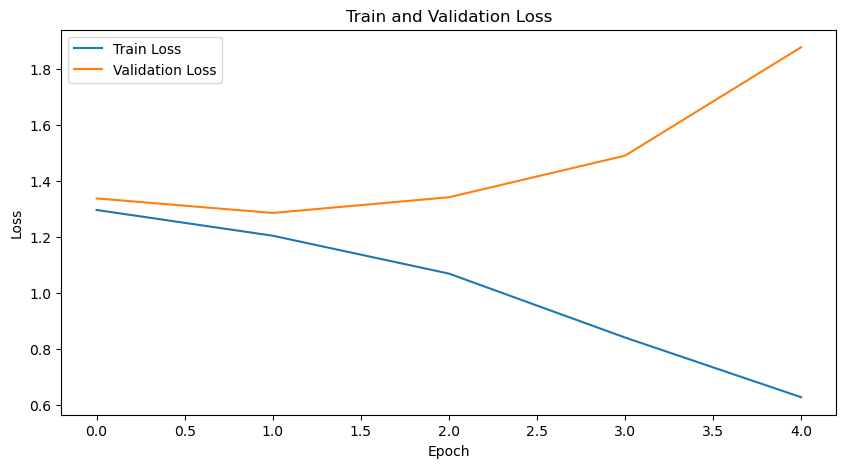

In [ ]:
# 检查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 将模型和损失函数移到 GPU
model = model.to(device)
criterion = criterion.to(device)

best_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 3
num_epochs = 30
best_model_state_dict = None
train_losses = []
val_losses = []

# Training Loop with Early Stopping and tqdm progress bar
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # 使用 tqdm 包裹 dataloader，显示训练进度
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = focal_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # 验证模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = focal_loss(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(test_dataloader)
    val_losses.append(val_loss)
    
    # 调整学习率
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Early Stopping 检查
    if val_loss < best_loss:
        best_loss = val_loss
        best_model_state_dict = model.state_dict()  # 保存最佳模型
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= n_epochs_stop:
            print("Early stopping!")
            break

# 绘制训练和验证损失
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()


### Evaluate and Accuracy

In [20]:
model.eval()  # 设置模型为评估模式
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():  # 禁用梯度计算
    for batch in test_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # 模型预测
        outputs = model(inputs)  # 输出 logits
        probs = torch.softmax(outputs, dim=1)  # 转化为概率

        # 获取预测标签
        _, preds = torch.max(probs, dim=1)

        # 收集真实标签和预测结果
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 转换为 numpy 数组
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# 计算 F1 分数（对于多分类任务可以设置 average='macro' 或 'weighted'）
f1 = f1_score(all_labels, all_preds, average='macro')  # 'macro' 适用于多分类
print(f"F1 Score: {f1:.4f}")


F1 Score: 0.2956


测试结果：
    CrossEntropy Loss:
    hidden_dim = 1024       nhead = 8        num_layers = 8        dropout = 0.1        lr = 0.001  f1 = 0.15
    hidden_dim = 1024       nhead = 4        num_layers = 4       dropout = 0.1        lr = 0.001   f1 = 0.32
    hidden_dim = 1024       nhead = 4        num_layers = 2       dropout = 0.1        lr = 0.001   f1 = 0.2956



    Focal Loss:
    

